In [1]:
#modeling sky subtraction model vs data points for 5/19/17 night
from __future__ import division

import os

import numpy as np

from glob import glob

import reduce_dblspec

import astropy

from astropy.io import fits
from astropy import units as u
from astropy.table import Table

from astropy import modeling
from astropy.modeling import models, fitting

from astropy import constants as cnst
%matplotlib inline
from matplotlib import pyplot as plt
import pipeline
from photutils import centroid_com
from astropy import units as u

In [2]:
#amending pipeline code to get sky subtraction separate from 1d spec

def sky_subtract(comb,skyaps,model):    
    #plotting 2D to get skyaps right around the target
    plt.figure(figsize=(10,25)) #setting up fig size
    value = model[1]
    if model == 'linear':
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Linear1D(1,0)) #(1,0)
    elif model == ('poly',value):
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Polynomial1D(value)) #Linear1D(1/10,10)) #(1,0)
    elif model == ('combined',value):
        mymodel=(modeling.models.Polynomial1D(value) + modeling.models.Linear1D(1,0))
        subimg, models = comb.subtract_sky(skyaps, skymodel=mymodel)
    elif model == None:
        subimg, models = comb.subtract_sky(skyaps, skymodel=None)#subtracts mean
    else:
        print ("Model type or polynomial degree not recognized")
    return (subimg, comb, models)    #subtracted2D, original, fitted models per row


def show_image(comb, **kwargs): #comb-self
        """
        Matplotlib imshow of this image

        transpose image for blue side unless transpose=False is given

        if log=True is given,the whole image will be linearly rescaled to 1-100
        before log-ifying, possibly be vmin/vmax
        """
        from matplotlib import pyplot as plt

        kwargs.setdefault('interpolation', 'nearest')
        kwargs.setdefault('transpose', self.side=='blue')

        if kwargs.pop('log', False):
            safedata = self.data[np.isfinite(self.data)]
            #use vmin and vmax to rescale  1-100
            lmin = kwargs.pop('logmin', None)
            lmax = kwargs.pop('logmax', None)
            mx = lmax if lmax else np.max(safedata)
            mi = lmin if lmin else np.min(safedata)
            rescaleddata = ((comb.data - mi) / (mx - mi)) #comb-self
            rescaleddata[rescaleddata>1] = 1
            rescaleddata[rescaleddata<0] = 0
            d = np.log10(rescaleddata*99.+1.)
        else:
            d = comb.data #comb-self
        if kwargs.pop('transpose'):
            d = d.T
        res = plt.imshow(d, **kwargs)
        return res

    
def target_1d(subimg,specaps,ds):    
    flux, unc = subimg.extract_spectrum(specaps)
    #plotting 1D extraction of target
    plt.subplot(212)
    plt.step(ds.pixtowl(np.arange(len(flux))), flux)
    plt.title('1D Target Spectrum')
    plt.ylabel('flux -- but ask Erik to be sure (counts/units?)')
    plt.xlabel('wavelength')
    #based below limit choices on info on palomar dblspec webpage
    if header['IRAFNAME']=='FeAr.spec': #blueside
        print('choose 1D target spec axis limits for blueside')
        plt.xlim(2800, 7000) #3600,5800 
        plt.ylim(0, plt.ylim()[-1])
    elif header['IRAFNAME']=='henear.spec': #redside
        print('choose 1D target spec axis limits for redside')
        plt.xlim(4700, 11000)
        plt.ylim(0, plt.ylim()[-1])
    return (flux, unc)

#below kinda replaces 'target_1d' above
#defining a function will use later to extract target's 1D spectrum from whole 2D data file 
def extract_spectrum(side, subtracted_2d, aperture):
        """
        Extract a 1D spectrum the "simple" (non-Horne) way
        
        Parameters
        ----------
        aperture : 2-tuple
            The edges of the aperture along the spatial axis
            
        Returns
        -------
        spectrum : array
            A 1D extracted spectrum with the *sum* of the flux.
        unc : 1D array
            The flux uncertainty matching the extracted spectrum
        """

        apslc = aperture if isinstance(aperture, slice) else slice(*aperture)
        if side == 'red':
            d = subtracted_2d.data
        elif side == 'blue':
            d = subtracted_2d.data.T
        else:
            raise ValueError('unrecognized side ')
        spec = np.sum(d[apslc], axis=0)
        unc = np.sum(d[apslc]**2, axis=0) ** 0.5
        unsum_spec = d[apslc]
        return spec, unc, unsum_spec #spec-1D spectrum for target
#spec is summed data for each pixel column(wl) within the spec aps range

# Subtracting Instrumentation Noise

In [3]:
#Finding all data file for specific target and doing instrumentation noise subtraction
#stating specific files/names to search for later on

flatid = 'DomeFlat'
atlasfiles = fits.open('henear.fits') #use for creating dispersion solution later 
targetID = '79005021831220-Catch22'
all_side_files_target = 'DoubleSpec/20170518/red*.fits'

#determing what instumentation noise is
flats = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim() for fn in 
          reduce_dblspec.find_all_obj(flatid,'DoubleSpec/20170518/red*.fits')[:10]] #DO I WANNA KEEP AS ONLY LAST 10???
nfl = reduce_dblspec.create_normalized_flat(flats)   
header = atlasfiles[0].header    
    
#locating all files w/ the target & instrumentation noise subtraction
specs = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim().flatten(nfl) 
          for fn in reduce_dblspec.find_all_obj(targetID,all_side_files_target)]
#specs is the inst. noise subtracted group of files with data from target    
    
print("This is lenspecs:",len(specs))

print('specs is the inst. noise subtracted group of files with data from target ')

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


This is lenspecs: 5
specs is the inst. noise subtracted group of files with data from target 


# Creating Dispersion Solution

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


used atlas plot limits for Red side


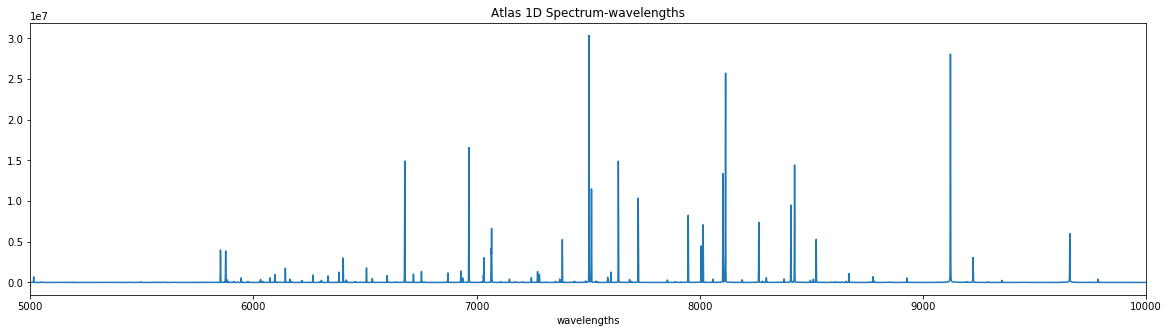

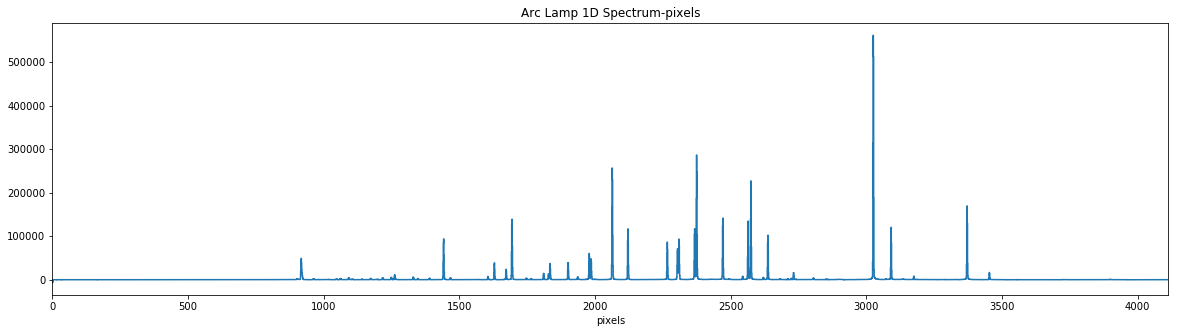

In [4]:
#creating a ds _ part one

#nameing all the datafiles needed
all_side_files_red10 = '20170518/red*.fits' #redside
atlasfiles_red10 = fits.open('henear.fits') #NOAO atlas #redside
arcfiles_red10 = '20170518/red0012.fits' #redside
linelist_red10 = reduce_dblspec.HENEAR_LINE_LIST

specset_red10 = pipeline.dispersion(all_side_files_red10, atlasfiles_red10, arcfiles_red10, linelist_red10,flatid)

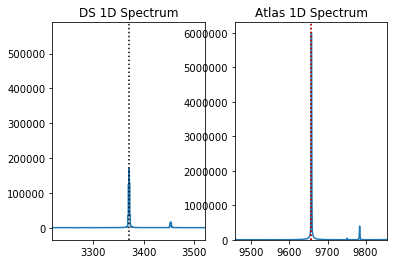

In [5]:
#creating a ds _ part two


#collecting guesses of matching lines from above graphs
#entering (px,wl)guesses & data
pipeline.guess_plot(3370,9657,specset_red10) #outputs (pixel guess, nearest wl/id in linelist)

#collect guesses here ~5 seems good
pixel_guesses_red10 = [3024,2373,2062,1672,3370]
atlas_lines_red10 = [9122.9674,8115.311,7635.106,7032.4131,9657.7863]
guesses_red10 = list(zip(pixel_guesses_red10, atlas_lines_red10)) #making tuples to pass into fcn later

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for redside
chose guesses for redside
Skipping line HeI at wl=3187.745 - out of wl min/max
Skipping line ArII at wl=3307.2283 - out of wl min/max
Skipping line ArI at wl=3319.3446 - out of wl min/max
Skipping line ArII at wl=3350.9243 - out of wl min/max
Skipping line HeI at wl=3354.55 - out of wl min/max
Skipping line ArI at wl=3373.4823 - out of wl min/max
Skipping line ArII at wl=3376.4359 - out of wl min/max
Skipping line ArII at wl=3388.5309 - out of wl min/max
Skipping line NeII at wl=3397.866 - out of wl min/max
Skipping line ArI at wl=3406.1804 - out of wl min/max
Skipping line ArII at wl=3414.4583 - out of wl min/max
Skipping line NeI at wl=3417.9035 - out of wl min/max
Skipping line ArII at wl=3421.6107 - out of wl min/max
Skipping line ArII at wl=3454.0952 - out of wl min/max
Skipping line ArII at wl=3464.1272 - out of wl min/max
Skipping line NeI at wl=3472.5711 - out of wl min/max
Skipping line ArII at wl=3476.7474 - out of wl min/max
Skipping line ArII at wl=3480

Clipped 0 lines
Failed to find line ArI at wl=7272.9359: "Guessed line's peak to base ratio is 7.605442276448056, which is less than 10"
Found line HeI at wl=7281.349
Clipped 0 lines
Failed to find line ArI at wl=7353.293: "Guessed line's peak to base ratio is 1.440416352893276, which is less than 10"
Failed to find line ArI at wl=7372.1184: "Guessed line's peak to base ratio is 1.886015039320914, which is less than 10"
Found line ArI at wl=7383.9805
Clipped 0 lines
Failed to find line NeI at wl=7488.8712: "Guessed line's peak to base ratio is 2.4296461377363423, which is less than 10"
Found line ArI at wl=7503.8691
Clipped 0 lines
Found line ArI at wl=7514.6518
Clipped 0 lines
Failed to find line NeI at wl=7535.7739: "Guessed line's peak to base ratio is 2.480156090889031, which is less than 10"
Failed to find line NeI at wl=7544.0443: "Guessed line's peak to base ratio is 1.2925552080633658, which is less than 10"
Failed to find line KrI at wl=7587.413: "Guessed line's peak to base r

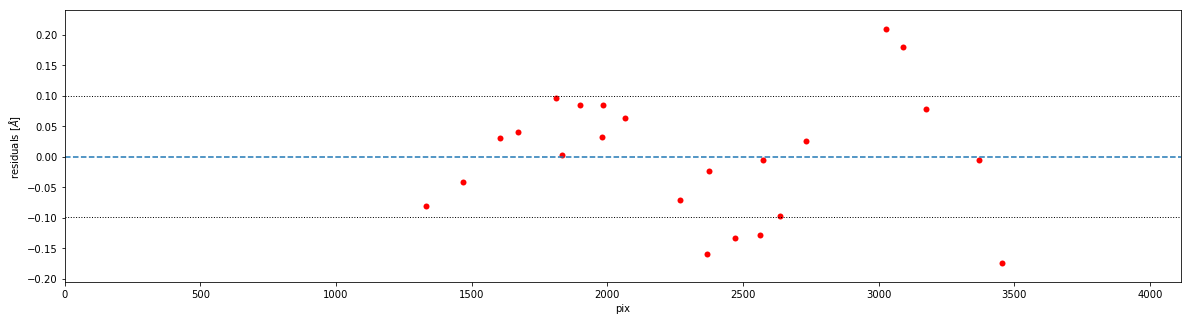

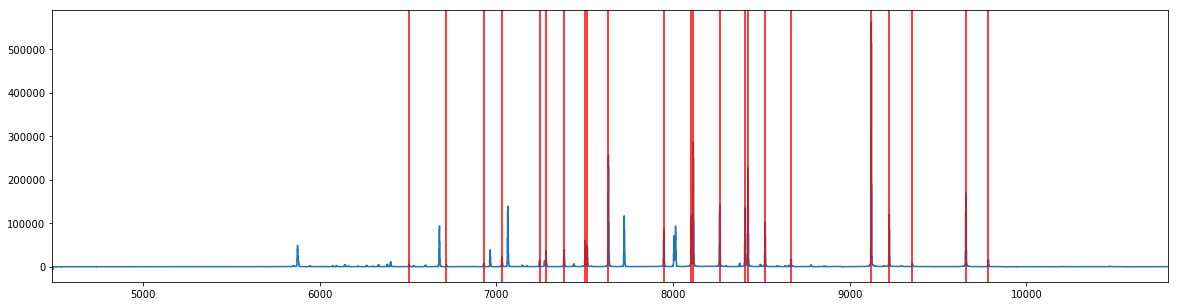

In [6]:
#creating a ds _ part three
ds_red10 = pipeline.goodness_of_matches(arcfiles_red10,guesses_red10,all_side_files_red10,atlasfiles_red10,linelist_red10,flatid);

#this is the final ds to apply to catch22 data for this entire nb

# Sky Subtraction & stacking --target data still 2D

In [7]:
#stacking all those instrument-noise-subtracted target data files-help increase s/n 

comb = reduce_dblspec.combine_imgs(specs) #comb-all files data from target stacked
skyaps=[(20,33),(265,320)]#[(55,120),(190,350)] #target 35-260
#skyaps=[(30,110),(180,400)] 
model=('poly',2)

subimg2, comb2, fitmodels = sky_subtract(comb,skyaps,model)
#subimg2 is sky-subtracted, instumentation noise subtracted, stacked data
#comb2 is original instrumentation noise subtracted, stacked data
#fitmodels is sky lines fitted to 'model' type

# Sanity Check

[ -6.35448395e+01   6.67014764e+01  -8.01993183e+02 ...,  -1.46522451e-01
  -3.74183006e-01  -1.10346141e+00]


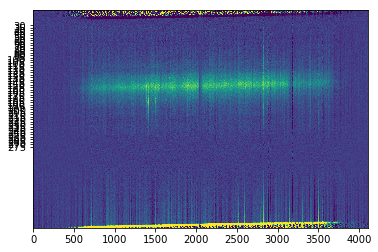

In [8]:
# SANITY CHECK

#first: want to see this newly cleaned 2d data visually
mydata=subimg2.data
vmin=-10
vmax=45
#plt.figure(figsize=(25,20)) ##REMOVE THIS LINES # TO SEE GRAPH USEFULNESS!!!!!!!!!!!!!!!!!!!!!!!!!

#instead of show_image function at top, doing this to estimate spatial row limits of H-alpha emission 
import matplotlib.ticker as plticker
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
plt.yticks(np.arange(30,280,5))
plt.imshow(mydata,aspect='auto',interpolation='nearest',vmin=vmin,vmax=vmax)

#second: now want to see newly cleaned data in numbers
print(subimg2.data[::][0])

In [9]:
#third: still exploring newly cleaned 2d data's format 
subimg2.header #subimg2 is sky & instr. subtracted stacked file
subimg2.data # flux is horiz.rows, wl is vertical columns

array([[ -6.35448395e+01,   6.67014764e+01,  -8.01993183e+02, ...,
         -1.46522451e-01,  -3.74183006e-01,  -1.10346141e+00],
       [ -6.56337357e+01,   6.85343634e+01,  -7.90691730e+02, ...,
          1.70647291e+00,   1.98860936e+00,   4.23329582e+00],
       [ -5.51667099e+01,   5.67780002e+01,  -7.71579219e+02, ...,
         -2.78473796e+00,  -4.65703081e+00,   7.35373758e-01],
       ..., 
       [ -5.85333640e+02,   4.28705913e+02,  -2.65243480e+03, ...,
          9.92516961e+00,   6.84470260e+00,  -4.45980143e+00],
       [ -7.38228216e+02,   4.29337799e+02,  -2.68054492e+03, ...,
          2.36865255e+00,  -5.99797231e+00,   8.07396868e+00],
       [ -7.28277178e+02,   4.07482835e+02,  -2.72690625e+03, ...,
          3.02872143e+00,  -2.94687367e+00,   1.84332008e+00]])

In [10]:
#still doing 'third' above
np.shape(comb2.data) #comb2 is only instr. subst. NOT sky-subst

(440, 4114)

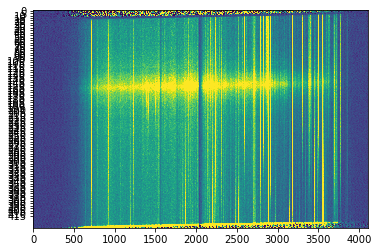

In [11]:
#fourth: want to see the un-skysubtracted data (but still instrument noise subtracted and stacked)
mydata=comb2.data #original stacked data
vmin=-10
vmax=45
#plt.figure(figsize=(25,20)) ##REMOVE THIS LINES # TO SEE GRAPH USEFULNESS!!!!!!!!!!!!!!!!!!!!!!!!!

plt.yticks(np.arange(0,420,5))
plt.imshow(mydata,aspect='auto',interpolation='nearest',vmin=vmin,vmax=vmax)

In [12]:
#original raw shape of 2d data for reference
np.shape(comb2.data)

(440, 4114)

# Extracting target 2D spectrum (reducing spatial parameters)

FLUX_DATA IS THE TARGET'S 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE (minus first 10 wls), NOT HALPHA ISOLATED!!!!!!!!!!!!!!!!!!!!!!!
flux data shape: (226, 4104)
NOTE THIS CELL CUTS OFF FIRST 10 PIXELS OF DATA FROM ENTIRE CCD SIZE DATASET DUE TO OSCILLS


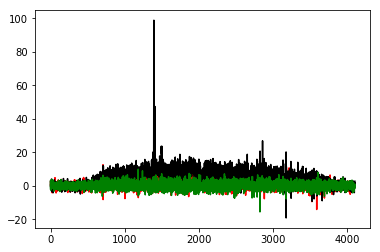

In [13]:
#first need to get 1D spectrum for each spatial pixel row in the 2D target data

#extracting target spec from whole 2d spec
#specaps=(35,260)
aperature=(35,260) #target location
flux_data=[] #empty list to hold target 2d spec
apslc = np.arange(aperature[0],aperature[1]+1,1) #makes list for which rows to extracct spec from
#print (apslc) #as expected, +1 so doesnt cut off last value

#np.shape(subimg2.data)#(440, 4114)
for i in apslc:
    spec = subimg2.data[i]#subimg2 is sky-subtracted 2D spec #this is every row's spec...
    
    #need to change if suming multiple pixel rows
    spec = spec[10::] #chops first 10 flux values in spectral (wl) direction-crazy osscillations
    flux_data.append(spec) #collects a list of every row's spec within the target location
flux_data=np.array(flux_data)   
print("FLUX_DATA IS THE TARGET'S 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE (minus first 10 wls), NOT HALPHA ISOLATED!!!!!!!!!!!!!!!!!!!!!!!" )
#need to find a way to sum over diff ranges of apslc 

plt.plot(flux_data[45],color='r')#near galaxy edge
plt.plot(flux_data[145],color='k') #near galaxy center
plt.plot(flux_data[224],color='g')#near opposite galaxy edge

print('flux data shape:', np.shape(flux_data)) #(226, 4104)
print('NOTE THIS CELL CUTS OFF FIRST 10 PIXELS OF DATA FROM ENTIRE CCD SIZE DATASET DUE TO OSCILLS')

# H-alpha wl search 
### ---first need to apply ds and get wl-pix associations

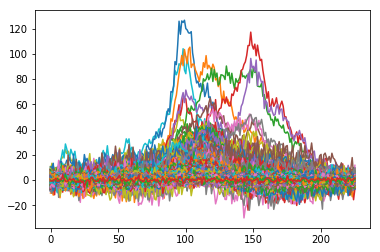

In [14]:
#exploring cell

plt.plot(flux_data);

In [15]:
#can delete if erik approves px-wl scripts in next cell

#testing for error in cell below
#len(flux_data[1])
#from scipy.optimize import newton
#help(newton)

# ASK in next cell when applying ds should be using flux_data or subimg2 data due to chopping of first 10 pixels

In [16]:
#good
#applying ds to get wl-pix associations


#applying ds
wl = ds_red10.pixtowl(np.arange(len(flux_data[1])))
px = []
for i in wl:
    pix = ds_red10.wltopix(wl[0])
    px.append(pix)
px = np.array(px)

#do the pixel plate scale too!!!!!!!!!!!!!!!!!!!!!!!!!
#need to fix radiusrange way above

r_in_arcmin = 1*u.arcmin# radial distance from centre of object in arcmin
distance = 5*u.Mpc # distance of object from us
r_in_kpc = (r_in_arcmin/u.rad*distance).to("kpc") # radial distance from centre of object in kpc

redplatescale = 0.293*u.arcsec/u.pixel
blueplatescale = 0.389*u.arcsec/u.pixel

dbsp_pix_equiv = u.pixel_scale(redplatescale)
r_in_pixel = 2*u.pixel
r_in_arcmin = r_in_pixel.to('arcmin', dbsp_pix_equiv)

r_in_arcmin

<Quantity 0.009766666666666667 arcmin>

In [17]:
#good
#checking ds gave 1-1 px-wl associations
#make this a table to carry around associations

print('wl:',wl)
print('px:',px)
print('px len:',len(px))
print('wl len:',len(wl))
index = np.arange(0,len(wl))
#px_to_wl = np.ndarray(index, px, wl) #doesnt work


wl: [  4488.43143529   4489.93082177   4491.43024058 ...,  10785.52808693
  10787.06954949  10788.61100023]
px: [ -6.78223812e-14  -6.78223812e-14  -6.78223812e-14 ...,  -6.78223812e-14
  -6.78223812e-14  -6.78223812e-14]
px len: 4104
wl len: 4104


In [18]:
#just exploring


#this is previously defined
#targetID = '79005021831220-Catch22'
#subimg2 comes out from running subtract sky function above -its instru & sky subtracted 2d data

#subimg2.header

### wl cut using z --lots of work but know what to do.

In [19]:
#still working on but problems

#need file of sats - hosts - hosts distance to pull from to determine a z...grrrr
import webbrowser


def findz(substracted_data,targetID):
    #doesnt appear to have a z in the header file so will need to use ra & dec 
    #and those codes erik gave to open safari and call sdss to get z values
    #check if z values are the same in sdss and saga google doc
    RA = substracted_data.header['RA']
    DEC = substracted_data.header['DEC']


In [20]:
    os.system("http://skyserver.sdss.org/dr13/en/tools/chart/navi.aspx?ra=RA&dec=DEC") #thats not gonna work



0

In [21]:
RA = 42
DEC = 35
address = "http://skyserver.sdss.org/dr13/en/tools/chart/navi.aspx?ra={:}&dec={:}".format(RA, DEC)
#print(address)
os.system(address) #google after this point but this is mostly for searching on computer

0

### h-alpha wl search ----change this to begin from determined z

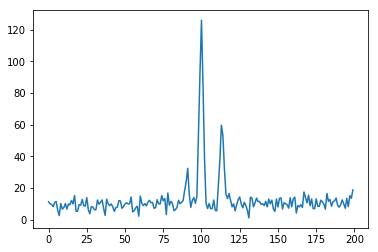

In [22]:
#good
#exploring sky subtracted 2d spec data

#getting a halpha spatial range for one row of the data
plt.plot(subimg2.data[130][1300:1500])

estimated pix of target center FOR ENTIRE CCD based on sky apps: 148
So estimated pix of target center FOR FLUX_DATA: 138
this is a good pixel range in spectral direction to isolate halpha for this target - may need to generalize more for others


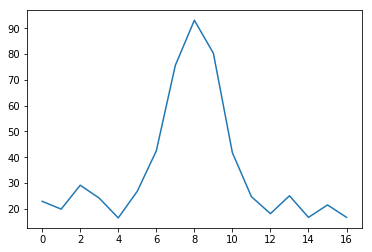

In [23]:
#good
#refining the wl range

#estimating core location using aperature values to isolate h-alpha wl
core_wrt_cutouttarget = (aperature[1] - aperature[0]) /2
core_wrt_entireccd = core_wrt_cutouttarget + aperature[0]
target_center = round(core_wrt_entireccd) #b/c cant slice if its not a whole integer

plt.plot(subimg2.data[target_center][1393:1410])#[1395:1408])#[1380:1420])
print('estimated pix of target center FOR ENTIRE CCD based on sky apps:',target_center)
print('So estimated pix of target center FOR FLUX_DATA:', target_center - 10)
print('this is a good pixel range in spectral direction to isolate halpha for this target - may need to generalize more for others')

In [24]:
np.shape(flux_data) #226,4104
np.shape(subimg2.data) #440,4114

print('why arent these the same lenghts? when did one get chopped? thats why sanity check below isnt the same wl cut range as above cell')
print('these were cut during the "Extracting target 2D spectrum: spatial reduction" step due to crazy osscilations-just subtract 10 from subimg2 value to match flux_data wls')

why arent these the same lenghts? when did one get chopped? thats why sanity check below isnt the same wl cut range as above cell
these were cut during the "Extracting target 2D spectrum: spatial reduction" step due to crazy osscilations-just subtract 10 from subimg2 value to match flux_data wls


# Sanity check

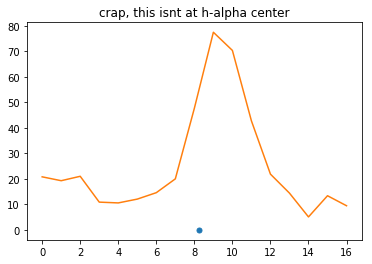

In [25]:
#good
#applied centroid to halpha reduced wl range....no ds applied...next cell tries to add ds
#currently all below is old notebook code but flux_data_short has info for this new notebook

flux_data_short2 = flux_data[:,1383:1400] #still guessing - need convert pix to wl here somehow
#guess will be calculated from target's z estimate of h-alpha wl location---will need to apply ds tho



#testing individual rows to see if centroid = halpha center 
#ASK ERIK ABOUT THIS PROBLEM


testha = flux_data_short2[138]#[62]seems ok but --> #130,180,148 also gives examples not centroiding to h-alpha peak
testnewha = testha[np.newaxis,:]
x_ha2,y_ha2 = centroid_com(testnewha)
plt.plot(x_ha2,y_ha2,'.',markersize=10)
plt.plot(testha);
plt.title('crap, this isnt at h-alpha center')

In [26]:
#part 1
#eriks method to keep track of slices made to data px-wl, px-flux
ypix, xpix = np.mgrid[:subimg2.data.shape[0], :subimg2.data.shape[1]]

In [27]:
#part 2
#eriks method to keep track of slices made to data px-wl, px-flux
cutout_slc = slice(None),slice(500,600) # [:, 500:600]
cutout_img =  subimg2.data[cutout_slc]
cutout_xpix = xpix[cutout_slc]
cutout_ypix = ypix[cutout_slc]

np.min(cutout_xpix)

500

# Sanity check bad so starting  Continum Subtraction

original flux_data: [ 1.6706282   0.00213418  1.0369824  ...,  1.62954368 -0.29461569
 -2.00102329]


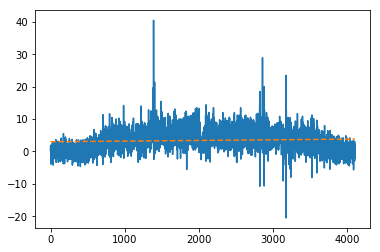

In [28]:
#good [but...........................ASK
#fit continum on whole ccd data or spatially cut out target only data?...................ASK
#lets try target only data for now b/c easier to keep with current progress]


#fitting continum (proof of concept first)

#before doing a for loop for entire target data gonna try technique on one spatial row
#want to fit continum using a low-order poly (linear even??) for each spatial pix(row)
plt.plot(flux_data[80])
flux_data[80]

#fitting a line to continum
testdata = flux_data[80]
xtest = np.linspace(0,len(testdata)) #evenly divides wl range into 50 even len sections
#x = np.array(np.linspace(0, testdata, 4))
xp = np.arange(0,len(flux_data[80]),1) #lists pixels by index
poly = np.poly1d(np.polyfit(xp,testdata, 1)) #fitting a straight line for now, can try higher order poly to improve
plt.xlabel=('spatial direction')
plt.ylabel=('"wl" of max emission (h-alpha)')
plt.plot(xtest,poly(xtest),'--')
print('original flux_data:',flux_data[80])

## Work leading up to continum subtraction from entire target

poly(xtest): (50,)
poly: (2,)
xtest: (50,)
xp: (4104,)
 
0.0002003 x + 3.004
one: 0.000200280866578
continum subtrated flux data [-1.33369286 -3.00185272 -1.96721176 ..., -1.37476916 -3.29854316 -5.004609  ]
original flux data: [ 1.6706282   0.00213418  1.0369824  ...,  1.62954368 -0.29461569
 -2.00102329]
just making sure testdata and original flux data are the same thing: [ 1.6706282   0.00213418  1.0369824  ...,  1.62954368 -0.29461569
 -2.00102329]
poly(testdata) [ 3.00432107  3.0039869   3.00419416 ...,  3.00431284  3.00392747
  3.00358571]


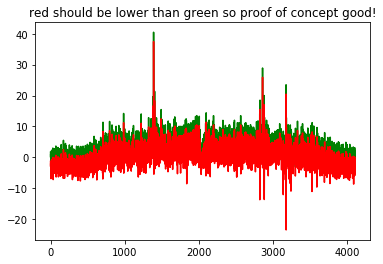

In [29]:
#good
#subtracting continum (proof of concept first)

#exploring
print('poly(xtest):',np.shape(poly(xtest)))
print('poly:',np.shape(poly))
print('xtest:',np.shape(xtest))
print('xp:',np.shape(xp))
print(poly)
print('one:',poly[1])

#subtracting continum fit
contsubt = testdata - poly(testdata)

print('continum subtrated flux data',contsubt)
print('original flux data:',flux_data[80])
print('just making sure testdata and original flux data are the same thing:',testdata)
print('poly(testdata)',poly(testdata))
np.shape(contsubt)
plt.title('red should be lower than green so proof of concept good!')
plt.plot(flux_data[80],color='g') #original flux
plt.plot(contsubt,color='r') #continum subtracted flux




shape new: (4104, 1)
new(80) [-3.21752031]
shape new(80) (1,)


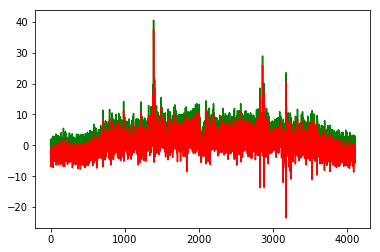

In [30]:
#good
#fitting continum for for single row of target data - good 1st step at for loop for entire target

#want to fit continum using a low-order poly (linear even??) for each spatial pix(row)
spatial_indexes = np.arange(0,len(flux_data))
#np.shape(spatial_indexes)
new = []
rows=[]


for row in flux_data[80:81]: #i isnt indiv data its each spatial row of data
    #xtest = np.linspace(0,len(row)) #evenly divides wl range into 50 even len sections
    #print(len(xtest))
    xpix = np.arange(0,len(row),1) #lists pixels by index
    #print(len(xpix))
    poly = np.poly1d(np.polyfit(xpix,row, 1)) #this determines the fit of the continum
    #new.append(poly(i)) #this applies the fit to every spatial row
    #print(len(poly(i)))#4104 each
#return poly
    for i in row: #this gives an oversubtration
        rows=[]
        subt_continum = i - poly(i)
        rows.append(subt_continum)
        new.append(rows)
new = np.array(new)
#new = np.reshape(new,(226,4104))#this is a quick fix for not being able to save in 2D format(each spatial row)



''' 
#not even sure whats happening here, result is crazy
    subt_continum = row - poly(row) 
    rows.append(subt_continum)
    new.append(rows)
    #plt.plot(subt_continum)

# this gives an odd shape (226, 1, 4104) and i cant access it to graph, but it prints..weird
    rows=[]    
    subt_continum = row - poly(row)
    #print(np.shape(subt_continum)) #(4104,)
    rows.append(subt_continum)
    new.append(rows)
    
#dont do this again it kills the kernal timeout
    for i in spatial_indexes: 
        j = flux_data[i]
        subt_continum = j - poly(j)
        rows.append(subt_continum)
        new.append(rows) 
        
    '''
#new = np.array(new)

print('shape new:',np.shape(new))
#plt.plot(new);
print("new(80)",new[80])
print('shape new(80)', np.shape(new[80]))

#plt.figure(figsize=(20,4))
#plt.ylim(-20,100)
#plt.xlim(-1,4105)
plt.plot(flux_data[80],color='g')#original data
plt.plot(new,color='r'); #subtracted data
#plt.plot(new,color='k');
#print('this is clearly an over subtraction, but how to fix???')

[[  1.67062820e+00   2.13417680e-03   1.03698240e+00 ...,   1.62954368e+00
   -2.94615689e-01  -2.00102329e+00]
 [ -6.55122549e-01   1.32901894e+00   2.28488657e+00 ...,   5.68777265e-01
   -1.44179528e+00  -3.79458520e+00]]
end
[ 1.6706282   0.00213418  1.0369824  ...,  1.62954368 -0.29461569
 -2.00102329]
[-0.65512255  1.32901894  2.28488657 ...,  0.56877726 -1.44179528
 -3.7945852 ]
(4104,)
x-axis whole integers are the divider btwn each row of data----------this statement allowed me to decide to do a transpose of the data when plotting and now looks as expected, so somethings twisted the data orientation


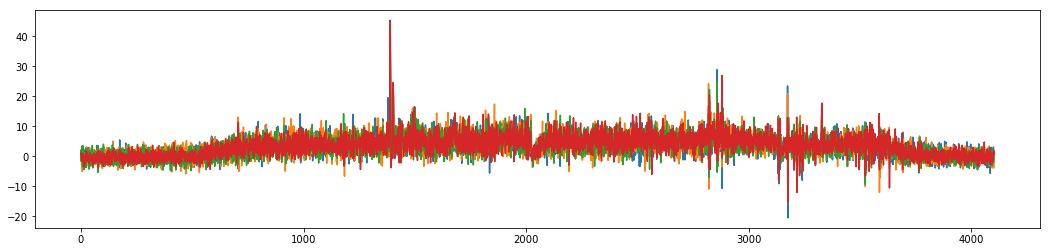

In [31]:
#good
#testing for below - keep this cell it informs the transpose


testd = flux_data[80:82]
#testda = testd[80]
#testda = te
plt.figure(figsize=(18,4))
plt.plot(flux_data[80:84].T)
print(flux_data[80:82])
print('end')
for i in flux_data[80:82]:
    print(i)
print(np.shape(i))
print('x-axis whole integers are the divider btwn each row of data----------this statement allowed me to decide to do a transpose of the data when plotting and now looks as expected, so somethings twisted the data orientation')

shape new: (20520, 1)
new(80) [-3.21752031]
shape new(80) (1,)
gonna try to extend this green plot to be like the red so data doesnt plot ontop of itself


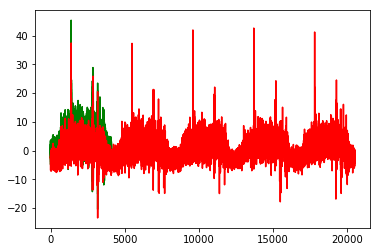

In [32]:
#good
#trying to recreate above but for a larger amount of rows at a time


#fitting continum for entire target now

#want to fit continum using a low-order poly (linear even??) for each spatial pix(row)
spatial_indexes = np.arange(0,len(flux_data))
#np.shape(spatial_indexes)
new = []
#rows=[]


for row in flux_data[80:85]: #i isnt indiv data its each spatial row of data
    #xtest = np.linspace(0,len(row)) #evenly divides wl range into 50 even len sections
    #print(len(xtest))
    xpix = np.arange(0,len(row),1) #lists pixels by index
    #print(len(xpix))
    poly = np.poly1d(np.polyfit(xpix,row, 1)) #this determines the fit of the continum
    #new.append(poly(i)) #this applies the fit to every spatial row
    #print(len(poly(i)))#4104 each
#return poly
    for i in row: #this gives an oversubtration
        rows=[]
        subt_continum = i - poly(i)
        rows.append(subt_continum)
        new.append(rows)
new = np.array(new)

print('shape new:',np.shape(new))
#plt.plot(new);
print("new(80)",new[80])
print('shape new(80)', np.shape(new[80]))

#plt.figure(figsize=(20,4))
#plt.ylim(-20,100)
#plt.xlim(-1,4105)
plt.plot(flux_data[80:85].T,color='g');
plt.plot(new,color='r');
print('gonna try to extend this green plot to be like the red so data doesnt plot ontop of itself')
#plt.plot(new,color='k');
#print('this is clearly an over subtraction, but how to fix???')

this is a good test of continum being subtracted from each spatial row, only prob is new subt data set is NOT divided into subarrays corresponding to each spatial row - instead its one long array - need to reshape it


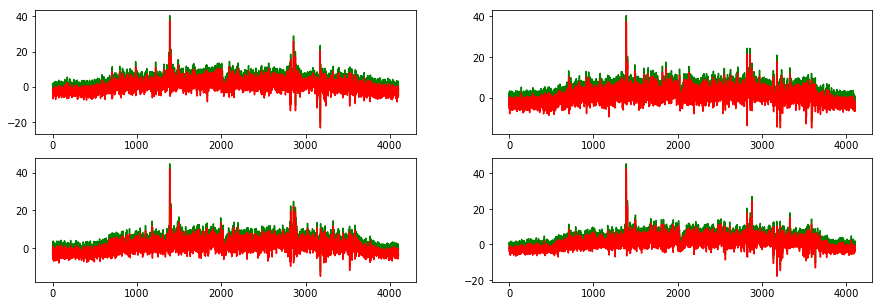

In [33]:
#good
#re-plotting above to see how to reshape subt data set and check if subtracting correctly for each space row
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15,5))
ax1.plot(flux_data[80],color='g') #original data
ax1.plot(new[0:4104],color='r') #cont subt data

ax2.plot(flux_data[81],color='g')
divide = 4104
ax2.plot(new[divide:2*divide],color='r')

ax3.plot(flux_data[82],color='g')
ax3.plot(new[2*divide:3*divide],color='r')

ax4.plot(flux_data[83],color='g')
ax4.plot(new[3*divide:4*divide],color='r')

print('this is a good test of continum being subtracted from each spatial row, only prob is new subt data set is NOT divided into subarrays corresponding to each spatial row - instead its one long array - need to reshape it')

In [34]:
#learning how to reshape subt data so each spatial row easily defined

#trying to automate values to use in reshape
amtofrows = int(len(new)/divide) #also ensured int not float
print('len(new):',len(new)) 
print('shape of new:',np.shape(new))
print('amtofrows:',amtofrows)



len(new): 20520
shape of new: (20520, 1)
amtofrows: 5


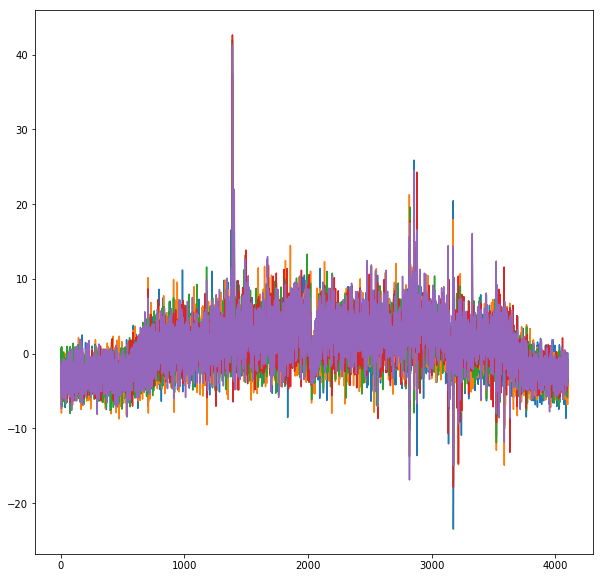

In [35]:
#reshaping
new = np.reshape(new,(amtofrows,divide))
plt.figure(figsize=(10,10))
plt.plot(new.T);

# Continum Subtraction for entire Target

shape new: (226, 4104)
new is the name of continum subtracted (and inst & sky subtracted, spatially reduced) 2d target data array
NOTE THAT THIS FIT, 12degpoly, SUBTRACTED ABSOLUTE VALUE OF CONTINNUM FIT POLY - W/O IT BECAME AN OVERSUBTRACTION AND MOST FLUX VALUES EXCEEDED ORIGINALS


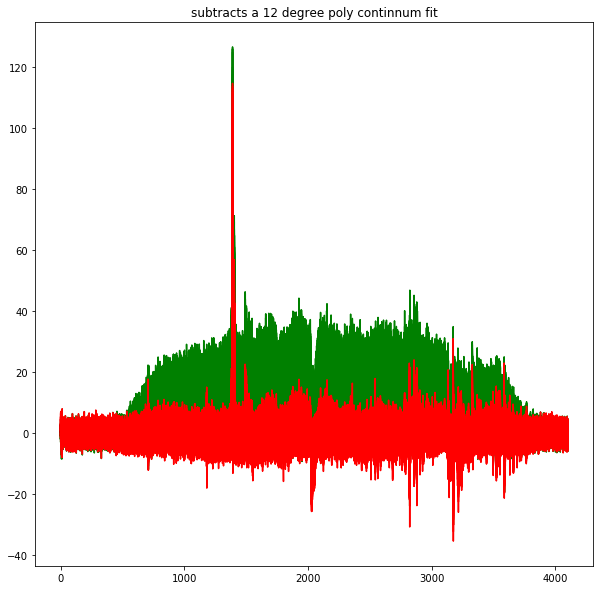

In [36]:
#good
#fitting continum for entire target now

#want to fit continum using a low-order poly (linear even??) for each spatial pix(row)
spatial_indexes = np.arange(0,len(flux_data))
new = []


for row in flux_data: #i isnt indiv data its each spatial row of data
    xpix = np.arange(0,len(row),1) #lists pixels by index
    polydeg = 12
    poly = np.poly1d(np.polyfit(xpix,row, polydeg)) #this determines the fit of the continum
    spec_subtracted = row - poly(xpix)
    new.append(spec_subtracted)
    
#below bad b/c poly(i) feeds it the index not flux value; replaced by erik above
##    for i in row: #this gives an oversubtration
##        rows=[]
##        subt_continum = i - poly(i)
##        rows.append(subt_continum)
##       new.append(rows)
new = np.array(new)

divide = 4104
amtofrows = int(len(new)/divide) #also ensured int not float
##new = np.reshape(new,(amtofrows,divide))
plt.figure(figsize=(10,10))
#plt.plot(new.T);

print('shape new:',np.shape(new))
#plt.plot(new);
#print("new(80)",new[80])
#print('shape new(80)', np.shape(new[80]))

#plt.figure(figsize=(20,4))
#plt.ylim(-20,100)
#plt.xlim(-1,4105)

plt.plot(flux_data.T, color='g'); #original data
plt.plot(new.T,color='r'); #continum subtracted data


plt.title('subtracts a {:} degree poly continnum fit'.format(polydeg))

print('new is the name of continum subtracted (and inst & sky subtracted, spatially reduced) 2d target data array')
print('NOTE THAT THIS FIT, 12degpoly, SUBTRACTED ABSOLUTE VALUE OF CONTINNUM FIT POLY - W/O IT BECAME AN OVERSUBTRACTION AND MOST FLUX VALUES EXCEEDED ORIGINALS')

# Sanity check
## again....but this time on cont subtracted data to see if helps with centroiding problem

new blue dot 8.43098745497 0.0
old blue dot 7.69383298367 0.0
okay there was a shift but not by much, it was shifted in the right direction too. But is this good enough? still seems pretty far from H-alpha center


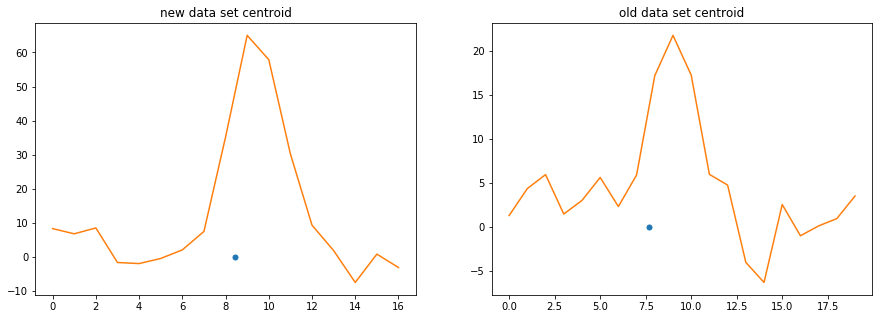

In [62]:
#start editing this now its just copy pasted in


#new data centroiding

new_short = new[:,1383:1400] #still guessing - need convert pix to wl here somehow
#guess will be calculated from target's z estimate of h-alpha wl location---will need to apply ds tho
new_testha = new_short[138]#[62]seems ok but --> #130,180,148 also gives examples not centroiding to h-alpha peak
new_testnewha = new_testha[np.newaxis,:]
new_x_ha2,new_y_ha2 = centroid_com(new_testnewha)
#new continum subt data
f, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(new_x_ha2,new_y_ha2,'.',markersize=10)
ax1.plot(new_testha);
ax1.set_title('new data set centroid')


#original data from way above bad sanity check just replotting for comparison here

ax2.plot(x_ha2,y_ha2,'.',markersize=10)
ax2.plot(testha);
ax2.set_title('old data set centroid')
print('new blue dot',new_x_ha2,new_y_ha2)
print('old blue dot',x_ha2,y_ha2)
print('okay there was a shift but not by much, it was shifted in the right direction too. But is this good enough? still seems pretty far from H-alpha center')


-36.4445175083 0.0


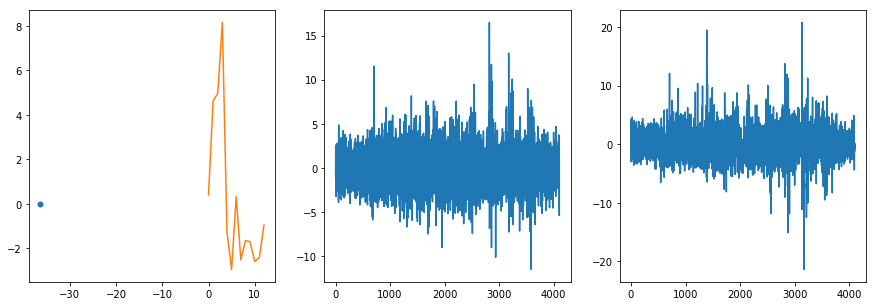

In [38]:
trying = new[27,1387:1400]
new_try = trying[np.newaxis,:]
x,y = centroid_com(new_try)
print(x,y)
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.plot(x,y,'.',markersize=10)
ax1.plot(trying);
ax2.plot(new[27]);
ax3.plot(new[66])


if things get messed up i did alot of renaming of old data sanity check here w/o being super careful so check here for double naming/renamings
new blue dot -36.4445175083 0.0
old blue dot 34.0067605782 -0.0
even tho the shift was to the left, this was still a correction in the right direction - toward the center of the emission. But again is this good enough?


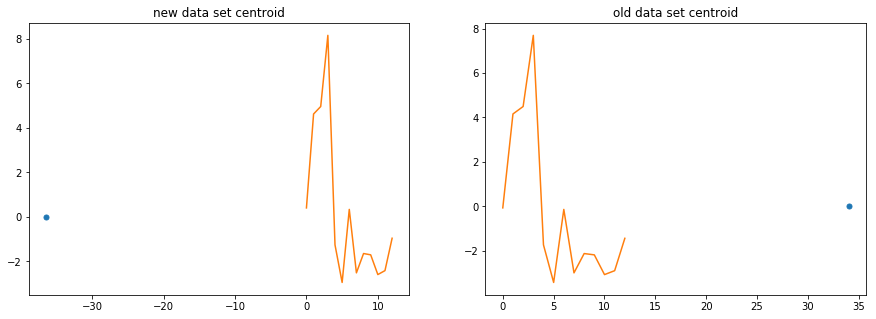

In [39]:
#trying above again but with even more isolated wl range around h-alpha

#new data centroiding

new_short2 = new[:,1387:1400] #still guessing - need convert pix to wl here somehow
#guess will be calculated from target's z estimate of h-alpha wl location---will need to apply ds tho
new_testha = new_short2[27]
new_testnewha = new_testha[np.newaxis,:]
new_x_ha2,new_y_ha2 = centroid_com(new_testnewha)
#new continum subt data
f, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(new_x_ha2,new_y_ha2,'.',markersize=10)
ax1.plot(new_testha);
ax1.set_title('new data set centroid')



#original data also edited for new wl range
flux_data_short3 = flux_data[:,1387:1400] #still guessing - need convert pix to wl here somehow
old_testha = flux_data_short3[27]
old_testnewha = old_testha[np.newaxis,:]
old_x_ha2,old_y_ha2 = centroid_com(old_testnewha)
ax2.plot(old_x_ha2,old_y_ha2,'.',markersize=10)
ax2.plot(old_testha);
ax2.set_title('old data set centroid')



print('if things get messed up i did alot of renaming of old data sanity check here w/o being super careful so check here for double naming/renamings')
#ax2.title('crap, this isnt at h-alpha center')
print('new blue dot',new_x_ha2,new_y_ha2)
print('old blue dot',old_x_ha2,old_y_ha2)
print('even tho the shift was to the left, this was still a correction in the right direction - toward the center of the emission. But again is this good enough?')

# Love above results - centroiding good now
# But!!!!!!!! works with reduced spectral range
# SO MIGHT NOT NEED BELOW UNTIL 'STOP'


# Redoing Continnum Fit with H-alpha removed first

original flux_data: [ 1.6706282   0.00213418  1.0369824  ...,  1.62954368 -0.29461569
 -2.00102329]
shape of xp,testdata (4104,) (4104,)
for some reason (illegal 4digit results) wont let poly go higher than 85 but even thats not fitting the H-alpha emissions --why not??


/Users/dee/miniconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RankWarning: Polyfit may be poorly conditioned
  


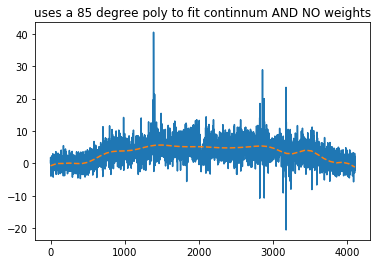

In [40]:
#doing continnum fit on data w/o H-alpha line.....testing proof of concept first

#just copied below from 1st proof of concept
#first wl range guess for H-alpha 1383:1400---make weights = 0 here
plt.plot(flux_data[80])
flux_data[80]

#fitting a line to continum
testdata = flux_data[80]
xtest = np.linspace(0,len(testdata)) #evenly divides wl range into 50 even len sections
#x = np.array(np.linspace(0, testdata, 4))
xp = np.arange(0,len(flux_data[80]),1) #lists pixels by index
polydeg = 85 #set degree of poly using to fit continnum
poly = np.poly1d(np.polyfit(xp,testdata, polydeg)) #fitting a straight line for now, can try higher order poly to improve
plt.xlabel=('spatial direction')
plt.ylabel=('"wl" of max emission (h-alpha)')
plt.plot(xtest,poly(xtest),'--')
plt.title('uses a {:} degree poly to fit continnum AND NO weights'.format(polydeg))

print('original flux_data:',flux_data[80])
print('shape of xp,testdata', np.shape(xp), np.shape(testdata))
print('for some reason (illegal 4digit results) wont let poly go higher than 85 but even thats not fitting the H-alpha emissions --why not??')
#plt.xlim(1000,2000)

In [41]:
#trying to set the weights
shape = (xp,testdata)
print('shape of shape',np.shape(shape))
w1 = np.ones(np.shape(shape),dtype=int)
print('shape of w1', np.shape(w1))
w1[:,1383:1400] = 0 #[int(0)]
#w2 = w1
print(np.where(w1 == 0)) #first array changes but not the second.....
print(w1[:,1383:1400]) #17 #but here both changed WTF

#tested with below in a sep cell
#for i in w1[1]: #have to do each array separately (2d) but both changed to = 0 at the right spot
#    print(i)
print('Did enough tests to believe this w1 is a good array for weights')

shape of shape (2, 4104)
shape of w1 (2, 4104)
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), array([1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393,
       1394, 1395, 1396, 1397, 1398, 1399, 1383, 1384, 1385, 1386, 1387,
       1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398,
       1399]))
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
Did enough tests to believe this w1 is a good array for weights


original flux_data: [ 1.6706282   0.00213418  1.0369824  ...,  1.62954368 -0.29461569
 -2.00102329]
shape of xp,testdata (4104,) (4104,)


/Users/dee/miniconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()


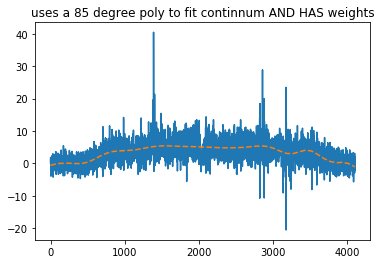

In [42]:
#trying with weights
plt.plot(flux_data[80])
flux_data[80]

#fitting a line to continum
testdata = flux_data[80]
xtest = np.linspace(0,len(testdata)) #evenly divides wl range into 50 even len sections
#x = np.array(np.linspace(0, testdata, 4))
xp = np.arange(0,len(flux_data[80]),1) #lists pixels by index
polydeg = 85 #set degree of poly using to fit continnum
poly = np.poly1d(np.polyfit(xp,testdata, polydeg, w=w1[0])) #fitting a straight line for now, can try higher order poly to improve
plt.xlabel=('spatial direction')
plt.ylabel=('"wl" of max emission (h-alpha)')
plt.plot(xtest,poly(xtest),'--')
plt.title('uses a {:} degree poly to fit continnum AND HAS weights'.format(polydeg))

print('original flux_data:',flux_data[80])
print('shape of xp,testdata', np.shape(xp), np.shape(testdata))

# 'STOP'

In [43]:
#
# for reference --- new_short = new[:,1387:1400]

# PROBLEMS BELOW, (WORK ABOVE SHOULD HELP): CENTROID ISNT USING Y-AXIS, ONLY X. ALSO HOW TO GET DS TO STICK?

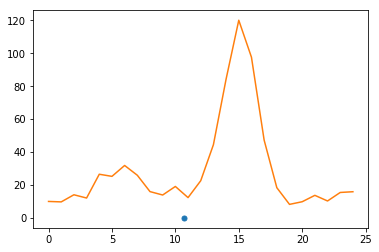

In [44]:
#good
#wl cut; apply ds; then do centroid

#wl cut
flux_data_short3 = flux_data[:,1375:1400]

#apply ds
wl_short = ds_red10.pixtowl(np.arange(len(flux_data[130])))

#centroid
test_ha2 = flux_data_short3[100]
test_new_ha2 = test_ha2[np.newaxis,:]
x_ha3,y_ha3 = centroid_com(test_new_ha2-50)

#plot
plt.plot(x_ha3,y_ha3,'.',markersize=10)
plt.plot(test_ha2);

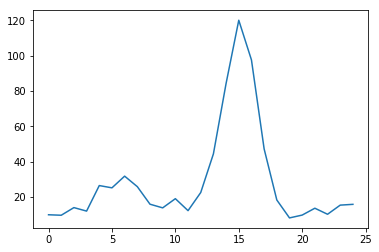

In [45]:
plt.plot(test_new_ha2[0])

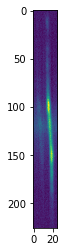

In [46]:
plt.imshow(flux_data_short3)

# H-alpha centroid trace

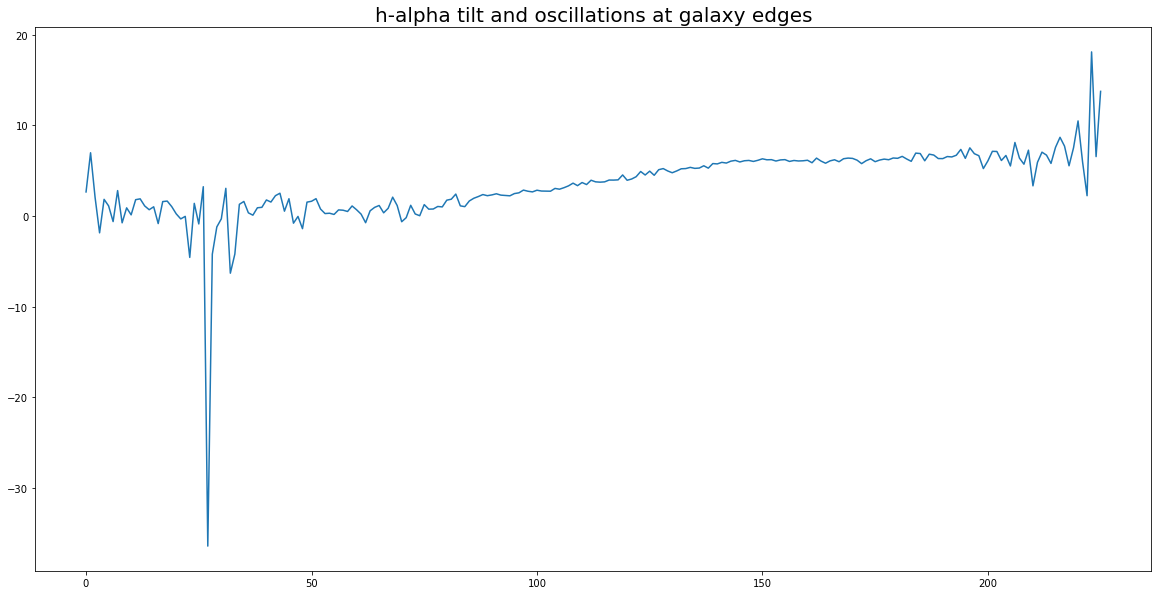

In [63]:
#trying with good centroids
# for reference this range works well for centroid--- new_short = new[:,1387:1400]



wl_shorter2 = wl[1387:1400] #wl is originally defined in ln[16] but wl_shorter is defed above cell & need to search below for other posible defs
mylist2 = []
mylist_ys2 = []
holding2 = []
ha_wls2 = []
for row in new_short2:
    flux_fake2d2 = row[np.newaxis, :] #makes each row array into a fake2d
    #print('row?',flux_fake2d)
    mylist4, mylist5 = centroid_com(flux_fake2d2)#finds center (x=2,y=3) of halpha for each row array
    #print(mylist4,mylist5)
    holding_arr2 = row, wl_shorter2
    x = np.array([row,wl_shorter2])
    mylist_ys2.append(mylist5)
    mylist2.append(mylist4) #collects all halpha centers per row
plt.figure(figsize=(20,10))
plt.xlabel=('pixel space still, spatial rows')
plt.ylabel=('x location of halpha center')
mylist2=np.array(mylist2)
plt.plot(mylist2)
plt.title('h-alpha tilt and oscillations at galaxy edges',fontsize=20)

# What is spike ~wl=27

# wl to velocity conversion

In [48]:
#good
#applying ds to get wl-pix associations


#applying ds
wl = ds_red10.pixtowl(np.arange(len(flux_data[1])))
px = []
for i in wl:
    pix = ds_red10.wltopix(wl[0])
    px.append(pix)
px = np.array(px)

#do the pixel plate scale too!!!!!!!!!!!!!!!!!!!!!!!!!
#need to fix radiusrange way above

r_in_arcmin = 1*u.arcmin# radial distance from centre of object in arcmin
distance = 5*u.Mpc # distance of object from us
r_in_kpc = (r_in_arcmin/u.rad*distance).to("kpc") # radial distance from centre of object in kpc

redplatescale = 0.293*u.arcsec/u.pixel
blueplatescale = 0.389*u.arcsec/u.pixel

dbsp_pix_equiv = u.pixel_scale(redplatescale)
r_in_pixel = 2*u.pixel
r_in_arcmin = r_in_pixel.to('arcmin', dbsp_pix_equiv)

r_in_arcmin

<Quantity 0.009766666666666667 arcmin>

In [49]:
print('wl:',wl)
print('px:',px)
print('px len:',len(px))
print('wl len:',len(wl))
index = np.arange(0,len(wl))

wl: [  4488.43143529   4489.93082177   4491.43024058 ...,  10785.52808693
  10787.06954949  10788.61100023]
px: [ -6.78223812e-14  -6.78223812e-14  -6.78223812e-14 ...,  -6.78223812e-14
  -6.78223812e-14  -6.78223812e-14]
px len: 4104
wl len: 4104


# Below was old trace attempt when centroid was bad - keep
# for reference for now

mylist (226,)
wl (20,)
LESSON LEARNED - NEED TO SUPER ISOLATE WL'S AROUND H-ALPHA


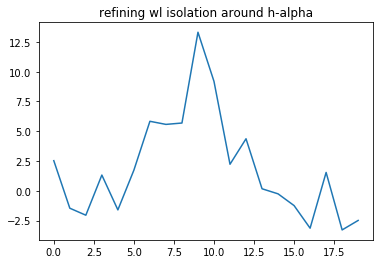

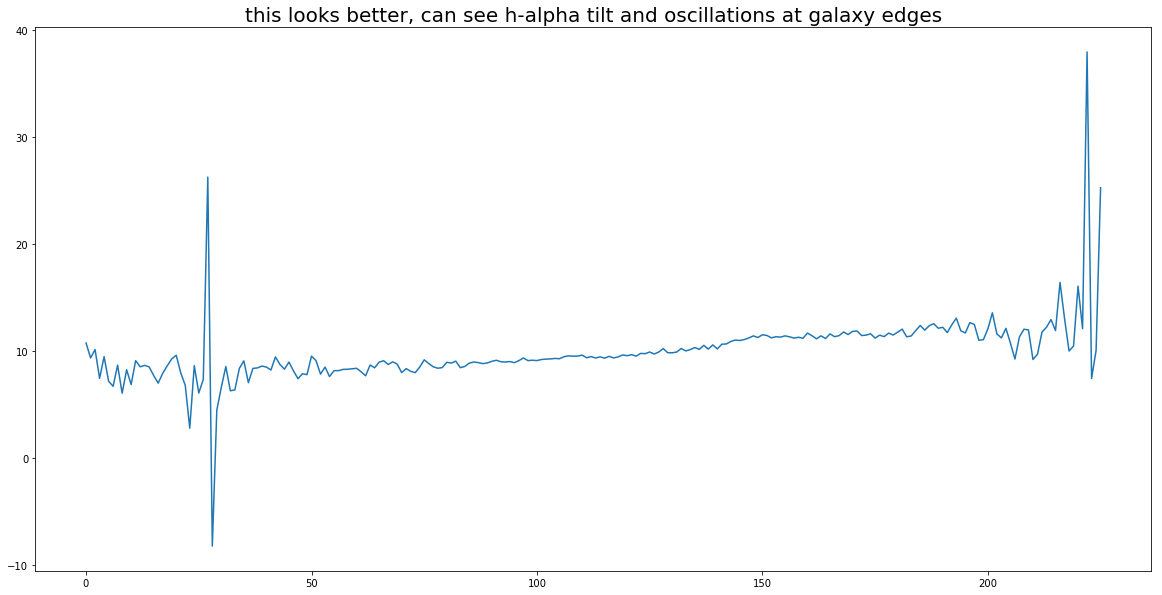

In [50]:
#good
#further refining h-alpha wl range from using z to get centroids (h-alpha emission per spaitial row) 


#applied ds in earlier cell, defined below
#wl = ds_red10.pixtowl(np.arange(len(flux_data[1])))


flux_data_short2 = flux_data[:,1380:1400] #still guessing - need convert pix to wl here somehow
#guess will be calculated from target's z estimate of h-alpha wl location---will need to apply ds tho


wl_shorter = wl[1380:1400]
plt.title('refining wl isolation around h-alpha')
plt.plot(flux_data_short2[22])

mylist = []
mylist_ys = []
holding = []
ha_wls = []
for row in flux_data_short2:
    flux_fake2d = row[np.newaxis, :] #makes each row array into a fake2d
    #print('row?',flux_fake2d)
    mylist2, mylist3 = centroid_com(flux_fake2d)#finds center (x=2,y=3) of halpha for each row array
    #hashed out showed that wl isnt isolated enough around halpha
    #plt.figure(figsize=(20,10))
    #plt.plot(row)
    #plt.plot(mylist2,mylist3,'.',markersize=10)
    holding_arr = row, wl_shorter
    x = np.array([row,wl_shorter])
    #x.shape = (20,20)
    #ha_wl = x(np.where(row == np.array(mylist2)))
    #print(ha_wl)
    #ha_wl3 = np.int(ha_wl)
    #ha_wl2 = wl_shorter[ha_wl3]
    #ha_wls.append(ha_wl2)
    mylist_ys.append(mylist3)
    mylist.append(mylist2) #collects all halpha centers per row
plt.figure(figsize=(20,10))
plt.xlabel=('pixel space still, spatial rows')
plt.ylabel=('x location of halpha center')
mylist=np.array(mylist)
plt.plot(mylist)
plt.title('this looks better, can see h-alpha tilt and oscillations at galaxy edges',fontsize=20)
print('mylist',np.shape(mylist))
print('wl',np.shape(wl_shorter))
#for i in mylist:
#    print(i)
print("LESSON LEARNED - NEED TO SUPER ISOLATE WL'S AROUND H-ALPHA")

### heart of question might be whats the relationship between halpha centroid value and wl, how to connect these in the code to get on the same graph b/c centroid is 'part of a pixel' but this isnt necessarily the same division/conversion of pixel space to wl used in the ds. [and does flux have a roll in this part? seems like it should when calculating mass per radius of galaxy but dont think it does in centroid trace.]

(104,)
is "below" in pixel? what are these values, no longer flux - this is the pixel location (rather than wl) of the halpha centroid?
[  9.5306492    9.78602938   9.76102962   9.91791613   9.72958873
   9.91207361  10.23979043   9.84883128   9.8437602    9.91317773
  10.2462804   10.0174995   10.1406956   10.33551141  10.16041015
  10.53866662  10.18856783  10.57919733  10.20819399  10.64330386
  10.67137401  10.90562561  11.03572898  10.99114823  11.08483722
  11.23696164  11.42447437  11.27290596  11.53010649  11.46215305
  11.23944874  11.3486467   11.30673977  11.42648762  11.33829344
  11.22105094  11.29484951  11.20175753  11.68717995  11.43798178
  11.15009685  11.42714826  11.17839165  11.61148907  11.34954879
  11.445104    11.79027634  11.55090274  11.84506727  11.8779596
  11.45723754  11.49507371  11.61762443  11.21652022  11.49173646
  11.35291484  11.68636716  11.50306201  11.77008333  12.05808156
  11.33576725  11.41861507  11.92382288  12.39710957  11.95979799
  12.37

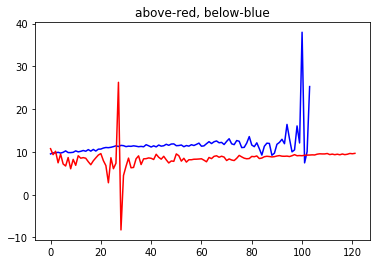

In [51]:
#good
#trying to plot h-alpha centroids to begin mass profile

mylist2 = [mylist]
mylist3 = np.reshape(mylist2,(226))
np.shape(mylist3)
#print(mylist3)  yha~121.8
above = mylist3[:122] #1,122
below = mylist3[122:] #1,104
print(np.shape(below))
plt.title('below')
below2 = below * (-1) #dont want this, desired effect should appear from wl
plt.plot(below,color='b');
print('is "below" in pixel? what are these values, no longer flux - this is the pixel location (rather than wl) of the halpha centroid?')
print(below)
plt.title('above-red, below-blue')
plt.plot(above,color='r');

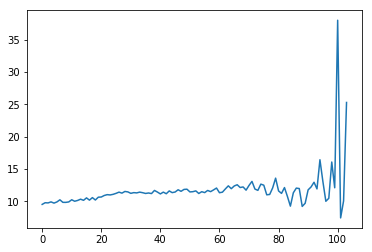

In [52]:
#good
#testing matrix order wrt core location.........part1


#copied below from previous notebook, expected below to 

mylist_test = [1,2,3,4,5,6,7]
mylist_test[4:5]
mylist_test[4]
#for i, j in enumerate(spatially_above_core[5]):
#    print('this is i:',i) #array number
#    print('this is j:',j)#flux value
plt.plot(below) #this is a problem....B/C AT EDGE OF GALAXY - LOW S/N!!!!!

ask erik about below interpretation
above and below plots show 0 is farthest from core, 112 pixel row is at the core?(b/c noiser-everywhere equally bright)
nope its opposite, good spec is at core[0], bad spec is near edge(112)


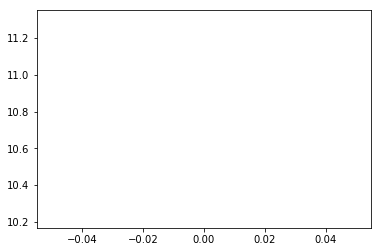

In [53]:
#good
#testing matrix order wrt core location...........part2


plt.plot(above[0]) #this is near core, good s/n
print('ask erik about below interpretation')
print('above and below plots show 0 is farthest from core, 112 pixel row is at the core?(b/c noiser-everywhere equally bright)')
print('nope its opposite, good spec is at core[0], bad spec is near edge(112)')

# Sanity check

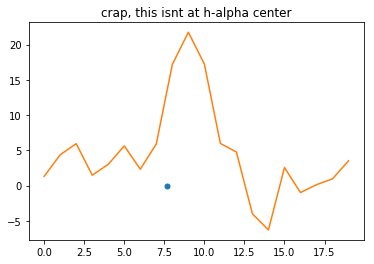

In [54]:
#good
#ASK ERIK ABOUT THIS PROBLEM
#testing individual rows to see if centroid = halpha center 

testha = flux_data_short2[62]
testnewha = testha[np.newaxis,:]
x_ha2,y_ha2 = centroid_com(testnewha)
plt.plot(x_ha2,y_ha2,'.',markersize=10)
plt.plot(testha);
plt.title('crap, this isnt at h-alpha center')

# maybe delete or amend below 2 cells b/c need more robust h-alpha wl range

In [55]:
#maybe delete this cell b/c its not robust enough to find halpha wl range


#trying to get a baseline for halpha (value at core)


tspec_range=np.arange(0,len(flux_data),1)
ha_zeropoint=np.max(flux_data[112]) #guessing middle of spaitial rows for halpha zero point
for i, j in enumerate(flux_data[112]):
    if j == np.max(flux_data[112]):
        halpha = i
        #halpha_data.append(halpha)
#print(halpha_data)
        print('halpha spatial location ("wl") value (taken from spatial row 1 pixel above core):',halpha)
print('halpha zeropoint estimated:',ha_zeropoint)

halpha spatial location ("wl") value (taken from spatial row 1 pixel above core): 1391
halpha zeropoint estimated: 83.3731282316


(226, 200)
THIS CELL HAS HALPHA ISOLATED SPEC DATAS TO USE THROUGHOUT!!!!!!!!!!!!!!!!!!!!!!!!!!


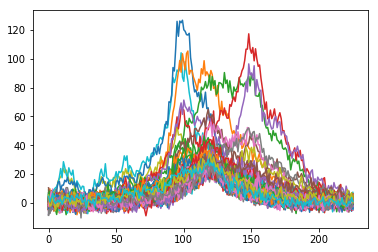

In [56]:
#getting halpha isolated for entire target spec


halpha_totalgalaxy = flux_data[:,1300:1500]
print(np.shape(halpha_totalgalaxy)) #yes this is correct (226,200)
print('THIS CELL HAS HALPHA ISOLATED SPEC DATAS TO USE THROUGHOUT!!!!!!!!!!!!!!!!!!!!!!!!!!')
plt.plot(halpha_totalgalaxy);

# Centroid Search for core

shape arr2d: (1, 226)
117.150852463


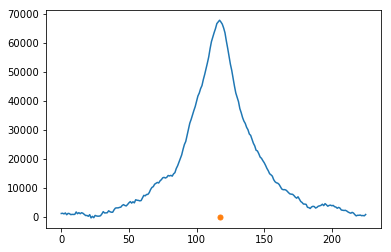

In [57]:
#find core using entire galaxy ----not reduced wl range surrounding halpha


#finding core via centroid FOR ENTIRE RED SIDE WL RANGE
#collasping along spectral direction

np.shape(flux_data) #226,4104
np.shape(np.sum(flux_data,axis=1)) #good, only want one wl, keep all 226 spatial rows
arr = np.sum(flux_data,axis=1) #explicitly making an array
arr2d = arr[:, np.newaxis] #needs to be 2d array for centroiding
print('shape arr2d:',np.shape(arr2d.T))#226,1
plt.plot(arr2d)#this looks promising
#tried arr2d & arr2d.T, same error
x4, y4 = centroid_com(arr2d.T) 
plt.plot(x4,y4,'.',markersize=10)

print(x4)

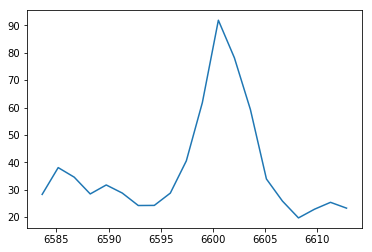

In [58]:
#good
#finding core via centroid FOR WL RANGE CLOSE TO HALPHA...part 1


#ds applied in earlier cell as defined below
#wl = ds_red10.pixtowl(np.arange(len(flux_data[1])))

#isolating halpha wl range but this isnt generalized and still cuts in pixel indexing
flux_data_short = flux_data[:,1380:1400]
wl_short = wl[1380:1400]
plt.plot(wl_short,flux_data_short[120]) #can only apply for one row at a time, need to do all at once

shape (226, 1)
x: 0.0 y: 121.886158568 y is the core in the spatial direction still in pixels tho...grr
notice its also weird order of plotting centroid
CORE IS AT SPATIAL PIXEL: 121.886158568


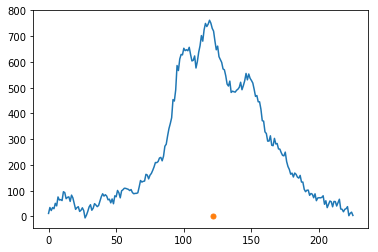

In [59]:
#good
#finding core via centroid FOR WL RANGE CLOSE TO HALPHA...part 2


#applying ds to each row
#probably junk cell now--NO

#specaps=(35,260)
#tspec_eachrow, unc, each_spec = extract_spectrum('red',subimg2, specaps)
#wl = ds_red10.pixtowl(np.arange(len(tspec_eachrow)))

#np.shape(each_spec)#this is a spec for each row thats been skysubtracted & ds applied (225,4114)




#compressing in wl space to one wl
flux_array = np.sum(flux_data_short,axis=1) #explicitly making an array
flux_array2d = flux_array[:, np.newaxis]


plt.plot(flux_array2d);

print('shape',np.shape(flux_array2d))

xha, yha = centroid_com(flux_array2d)
plt.plot(yha, xha ,'.',markersize=10)
print('x:',xha,'y:',yha, 'y is the core in the spatial direction still in pixels tho...grr')
print('notice its also weird order of plotting centroid')
spatial_core_pix = yha
print('CORE IS AT SPATIAL PIXEL:',yha)

this looks so much better - still not right but better, besides whats in title also need to make core the center and convert pix to wl
ha 226


ValueError: Polynomial must be 1d only.

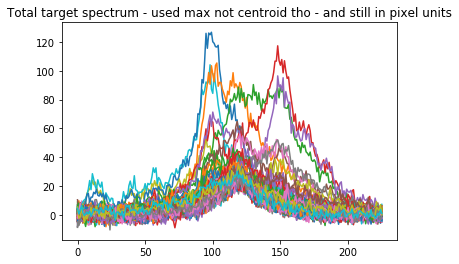

In [60]:
#good
#useful somewhere but need 1d of halpha_totalgalaxy


plt.plot(halpha_totalgalaxy)#[45:200]) #region between oscill in above cell
##plt.plot(wl[45:200],halpha_totalgal[45:200])
plt.title('Total target spectrum - used max not centroid tho - and still in pixel units')
print('this looks so much better - still not right but better, besides whats in title also need to make core the center and convert pix to wl')

#fitting a line
testdata = halpha_totalgalaxy#[45:200]
xtest = np.linspace(0,len(testdata))
#x = np.array(np.linspace(0, testdata, 4))
xp = np.arange(0,len(halpha_totalgalaxy),1)#[45:200]),1)
print('ha',len(halpha_totalgalaxy))#[45:200]))
#print('xp:',len(xp))
poly = np.poly1d(np.polyfit(xp,halpha_totalgalaxy,3))#[45:200], 3))
plt.xlabel=('spatial direction')
plt.ylabel=('"wl" of max emission (h-alpha)')
plt.plot(xtest,poly(xtest),'--')